# Identify tags in airline database

## Deep LSTM networks

    - Bidirectional LSTM
    - Stacked LSTM
    - Bidirectional stacked LSTM

In [1]:
from __future__ import print_function

import sys
import os 
import numpy as np 
import tensorflow as tf 
print(tf.__version__)

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

#Show images
import matplotlib.pyplot as plt
%matplotlib inline
# plt configuration
plt.rcParams['figure.figsize'] = (10, 10)        # size of images
plt.rcParams['image.interpolation'] = 'nearest'  # show exact image
plt.rcParams['image.cmap'] = 'gray'  # use grayscale 

1.3.0


## Dataset transformation


In [2]:
# Read data
import pickle

atis_file = '../data/atis/atis.pkl'

with open(atis_file,'rb') as f:
    if sys.version_info.major==2:
        train, test, dicts = pickle.load(f) #python2.7
    else:
        train, test, dicts = pickle.load(f, encoding='bytes') #python3

#Dictionaries and train test partition
w2idx, ne2idx, labels2idx = dicts[b'words2idx'], dicts[b'tables2idx'], dicts[b'labels2idx']
    
idx2w  = dict((v,k) for k,v in w2idx.items())
idx2la = dict((v,k) for k,v in labels2idx.items())

train_x, _, train_label = train
test_x,  _,  test_label  = test


# Max value of word coding to assign the ID_PAD
ID_PAD = np.max([np.max(tx) for tx in train_x]) + 1
print('ID_PAD: ', ID_PAD)

def context(l, size=3):
    l = list(l)
    lpadded = size // 2 * [ID_PAD] + l + size // 2 * [ID_PAD]
    out = [lpadded[i:(i + size)] for i in range(len(l))]
    return out


# Create train and test X y.
X_trn=[]
for s in train_x:
    X_trn += context(s,size=10)
X_trn = np.array(X_trn)

X_tst=[]
for s in test_x:
    X_tst += context(s,size=10)
X_tst = np.array(X_tst)

print('X trn shape: ', X_trn.shape)
print('X_tst shape: ',X_tst.shape)


y_trn=[]
for s in train_label:
    y_trn += list(s)
y_trn = np.array(y_trn)
print('y_trn shape: ',y_trn.shape)

y_tst=[]
for s in test_label:
    y_tst += list(s)
y_tst = np.array(y_tst)
print('y_tst shape: ',y_tst.shape)


print('Num labels: ',len(set(y_trn)))
print('Num words: ',len(set(idx2w)))

ID_PAD:  572
X trn shape:  (56590, 10)
X_tst shape:  (9198, 10)
y_trn shape:  (56590,)
y_tst shape:  (9198,)
Num labels:  121
Num words:  572


In [3]:
# data attributes
input_seq_length = X_trn.shape[1]
input_vocabulary_size = len(set(idx2w)) + 1
output_length = 127

#Model parameters
embedding_size=64
num_hidden_lstm = 128


In [4]:
from tensorflow.contrib.keras import layers, models, optimizers, utils, callbacks

# Bidirectional LSTM model


In [ ]:
# build the model: Simple LSTM with embedings
print('Build model 1')
seq_input = layers.Input(shape=([input_seq_length]), name='prev') 
    
embeds = layers.Embedding(input_vocabulary_size, embedding_size)(seq_input)

# Bidirectional LSTM
forwards  = layers.LSTM(num_hidden_lstm, return_sequences=False, name='Forward')(embeds)
backwards = layers.LSTM(num_hidden_lstm, return_sequences=False, go_backwards=True, name='Backward')(embeds)
rnn_out = layers.concatenate([forwards, backwards], axis=-1, name='Forward_Backward')

output = layers.Dense(output_length, activation='softmax')(rnn_out)

model1 = models.Model(inputs=seq_input, outputs=output)
model1.summary()

# Optimizer
adam_optimizer = optimizers.Adam()
model1.compile(loss='sparse_categorical_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])


#Fit model
tb_callback_bilstm = callbacks.TensorBoard(log_dir='/tmp/tensorboard/airline/BILSTM/')
history1 = model1.fit(X_trn, y_trn, batch_size=128, epochs=20,
                      validation_data=(X_tst, y_tst), callbacks=[tb_callback_bilstm])


# Stacked LSTM model

Build model 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prev (InputLayer)            (None, 10)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 10, 64)            36672     
_________________________________________________________________
Forward1 (LSTM)              (None, None, 128)         98816     
_________________________________________________________________
Forward2 (LSTM)              (None, 128)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 127)               16383     
Total params: 283,455
Trainable params: 283,455
Non-trainable params: 0
_________________________________________________________________
Train on 56590 samples, validate on 9198 samples
Epoch 1/20
56590/56590 [==============================] - 43s - loss: 1.5

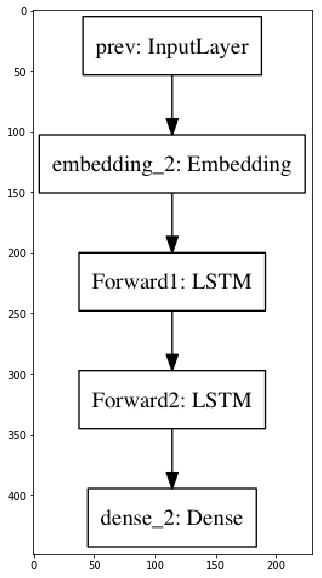

In [6]:
# build the model: Simple LSTM with embedings
print('Build model 1')
seq_input = layers.Input(shape=([input_seq_length]), name='prev') 
    
embeds = layers.Embedding(input_vocabulary_size, embedding_size)(seq_input)

# Stacked LSTM
forwards1 = layers.LSTM(num_hidden_lstm, return_sequences=True,  name='Forward1')(embeds)
forwards2 = layers.LSTM(num_hidden_lstm, return_sequences=False, name='Forward2')(forwards1)

output = layers.Dense(output_length, activation='softmax')(forwards2)

model2 = models.Model(inputs=seq_input, outputs=output)
model2.summary()

# Optimizer
adam_optimizer = optimizers.Adam()
model2.compile(loss='sparse_categorical_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])


#Fit model
tb_callback_lstm2 = callbacks.TensorBoard(log_dir='/tmp/tensorboard/airline/LSTM2/')
history2 = model2.fit(X_trn, y_trn, batch_size=128, epochs=20,
                      validation_data=(X_tst, y_tst), callbacks=[tb_callback_lstm2])


# Bidirectional stacked LSTM model

Build model 1
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
prev (InputLayer)                (None, 10)            0                                            
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 10, 64)        36672       prev[0][0]                       
____________________________________________________________________________________________________
Forward1 (LSTM)                  (None, None, 128)     98816       embedding_3[0][0]                
____________________________________________________________________________________________________
Backward1 (LSTM)                 (None, None, 128)     98816       embedding_3[0][0]                
_____________________________________________________________________________

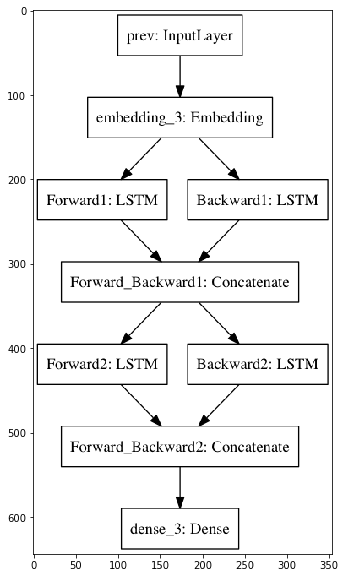

In [7]:
# build the model: Bidirectional stacked LSTM with embedings
print('Build model 1')
seq_input = layers.Input(shape=([input_seq_length]), name='prev') 
    
embeds = layers.Embedding(input_vocabulary_size, embedding_size)(seq_input)

# Bidirectional LSTM 1
forwards1  = layers.LSTM(num_hidden_lstm, return_sequences=True, name='Forward1')(embeds)
backwards1 = layers.LSTM(num_hidden_lstm, return_sequences=True, go_backwards=True, name='Backward1')(embeds)
rnn_out1 = layers.concatenate([forwards1, backwards1], axis=-1, name='Forward_Backward1')

# Bidirectional LSTM 1
forwards2  = layers.LSTM(num_hidden_lstm, return_sequences=False, name='Forward2')(rnn_out1)
backwards2 = layers.LSTM(num_hidden_lstm, return_sequences=False, go_backwards=True, name='Backward2')(rnn_out1)
rnn_out2 = layers.concatenate([forwards2, backwards2], axis=-1, name='Forward_Backward2')


output = layers.Dense(output_length, activation='softmax')(rnn_out2)

model3 = models.Model(inputs=seq_input, outputs=output)
model3.summary()

# Optimizer
adam_optimizer = optimizers.Adam()
model3.compile(loss='sparse_categorical_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])


#Fit model
tb_callback_bilstm2 = callbacks.TensorBoard(log_dir='/tmp/tensorboard/airline/BILSTM2/')
history3 = model3.fit(X_trn, y_trn, batch_size=128, epochs=20,
                      validation_data=(X_tst, y_tst), callbacks=[tb_callback_bilstm2])


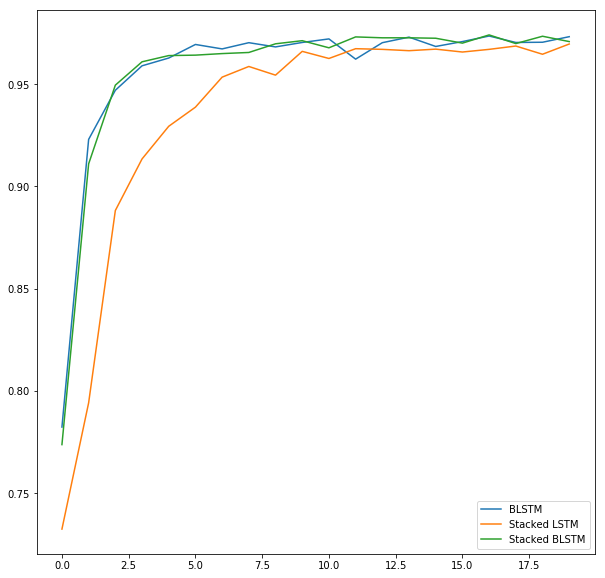

In [8]:
# Compare validation of the 3 models
plt.plot(history1.history['val_acc'], label='BLSTM')
plt.plot(history2.history['val_acc'], label='Stacked LSTM')
plt.plot(history3.history['val_acc'], label='Stacked BLSTM')
plt.legend(loc='lower right')
plt.show()